Source code used: https://github.com/moduIo/Deep-Q-network

# Imports and Package Installation

In [1]:
import random
import gym
import numpy as np
from collections import deque
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, GRU, Embedding
from tensorflow.keras.optimizers import Adam
from nltk.translate.bleu_score import corpus_bleu
from torch.nn.utils.rnn import pad_sequence
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

In [ ]:
!pip install flair

In [3]:
import pandas as pd
from flair.embeddings import WordEmbeddings, DocumentRNNEmbeddings
from flair.embeddings import TransformerDocumentEmbeddings
from flair.data import Sentence
import torch
from nltk.tokenize import sent_tokenize
import nltk
from nltk.translate.bleu_score import corpus_bleu
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Agent

In [4]:
class DQN_Agent:

    # Initializes attributes and constructs CNN model and target_model
    def __init__(self, state_size, action_size=2):
        self.state_size = state_size #state is BERT embeddings
        self.action_size = action_size #actions are either EXTRACT or CONTINUE
        self.memory = deque(maxlen=5000)
        
        # Hyperparameters
        self.gamma = 1.0            # Discount rate
        self.epsilon = 0.05       # Exploration rate
        self.epsilon_min = 1.0      # Minimal exploration rate (epsilon-greedy)
        self.epsilon_decay = 0.995  # Decay rate for epsilon
        self.update_rate = 1000     # Number of steps until updating the target network
        
        # Construct DQN models
        self.model = self.build_rnn_model()
        self.target_model = self.build_rnn_model()
        self.target_model.set_weights(self.model.get_weights())
        self.model.summary()


    #RNN + softmax policy model for action-value pairs
    def build_rnn_model(self):
        model = Sequential()
        model.add(Embedding(input_dim=self.state_size,output_dim=64))
        #units, activation='tanh'
        model.add(GRU(50, activation='tanh')) #GRU, 50 hidden units, tanh activation as per Lee et al. paper

        model.add(Dense(self.action_size, activation='softmax'))
        model.compile(loss='binary_crossentropy', optimizer='adam')
        return model


    # Stores experience in replay memory
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # Chooses action based on epsilon-greedy policy
    def act(self, state):
        # Random exploration
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        act_values = self.model.predict(state) #get action-value pairs
        return np.argmax(act_values[0])  # Returns action using policy

    # Trains the model using randomly selected experiences in the replay memory
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        
        for state, action, reward, next_state, done in minibatch:
            
            if not done:
                target = (reward + self.gamma * np.amax(self.target_model.predict(next_state))) #reward function
            else:
                target = reward
                
            # Construct the target vector as follows:
            # 1. Use the current model to output the Q-value predictions
            target_f = self.model.predict(state)
            
            # 2. Rewrite the chosen action value with the computed target
            target_f[0][action] = target
            
            # 3. Use vectors in the objective computation
            history_callback = self.model.fit(state, target_f, epochs=1, verbose=0) 
            #history_callback = model.fit(params...)
            #loss_history = history_callback.history["loss"]
            
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        loss_history = history_callback.history["loss"]
        #print(loss_history)
        return loss_history

    # Sets the target model parameters to the current model parameters
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
            
    # Loads a saved model
    def load(self, name):
        self.model.load_weights(name)

    # Saves parameters of a trained model
    def save(self, name):
        self.model.save_weights(name)

# Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
articles = pd.read_csv("/content/drive/MyDrive/Practical Deep Learning/Final_Project/articles1.csv")

In [ ]:
def get_doc_embeddings(text):
    """This method takes an article and uses GloVe
    embeddings and an RNN to generate an embedding
    representation for the entire document.
    """
    glove_embedding = WordEmbeddings('glove')
    document_embeddings = DocumentRNNEmbeddings([glove_embedding])
    sentence = Sentence(text)
    
    # embed the sentence with our document embedding
    document_embeddings.embed(sentence)
    return sentence.get_embedding()

In [ ]:
def get_sent_embeddings(text):
    """This method takes an article and uses RoBERTa to generate
    embeddings for each sentence in the article. Each sentence
    is embedded and stored in a list as a tuple of
    the embedding and the tokenized sentence.
    """
    embedding = TransformerDocumentEmbeddings('roberta-base')
    sent_embeddings = []
    for sentence in sent_tokenize(text):
        curr_sentence = Sentence(sentence)
        embedding.embed(curr_sentence)
        sent_embeddings.append((curr_sentence.get_embedding(), curr_sentence))
    return sent_embeddings

In [ ]:
def get_unigrams(sentence):
    unigrams = []
    for token in sentence:
        unigrams.append(str(token).split(" ")[2])
    return tuple(unigrams)

In [ ]:
example = articles.content[1]
example

'After the bullet shells get counted, the blood dries and the votive candles burn out, people peer down from   windows and see crime scenes gone cold: a band of yellow police tape blowing in the breeze. The South Bronx, just across the Harlem River from Manhattan and once shorthand for urban dysfunction, still suffers violence at levels long ago slashed in many other parts of New York City. And yet the city’s efforts to fight it remain splintered, underfunded and burdened by scandal. In the 40th Precinct, at the southern tip of the Bronx, as in other poor, minority neighborhoods across the country, people long hounded for   infractions are crying out for more protection against grievous injury or death. By September, four of every five shootings in the precinct this year were unsolved. Out of the city’s 77 precincts, the 40th has the highest murder rate but the fewest detectives per violent crime, reflecting disparities in staffing that hit hardest in some neighborhoods outside Manhatt

# Load Preprocessed Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pickle
import os
def loadData():
  directory = "/content/drive/MyDrive/Practical Deep Learning/Final_Project/data/"
  all_dicts = []
  for filename in os.listdir(directory):
    if filename=="articles1.csv":
      continue
    filepath = os.path.join(directory, filename)
    print(filename)
    # for reading also binary mode is important
    dbfile = open(filepath, 'rb')     
    try: 
      db = pickle.load(dbfile)
      all_dicts.append(db)
    except:
      print("could not pickle ", filename)
    dbfile.close()
    #break
  return all_dicts
    #return db


In [ ]:
all_doc_sents = loadData()
#len(doc_sents)

batch1
batch6
batch7
batch8
batch9
batch10
could not pickle  batch10
batch11
batch12
batch13
batch14
batch15
batch16
batch17
batch18
batch19
batch20
batch2
batch3
batch4
batch5


# Environment

In [ ]:
#partial summary is one_hot vectors
def update_partial_summary(partial_summ, sent_pos):
  ps = partial_summ #.numpy()
  ps[int(sent_pos)] = 1
  return ps

def calculate_reward(partial_summ, document_ref, sentence_embeddings):
  #bleu score
  #references = [[['this', 'is', 'a', 'test'], ['this', 'is' 'test']]]
  #candidates = [['this', 'is', 'a', 'test']]
  #return 1
  #print("document: ", document_ref)
  
  inds = np.where(partial_summ==1)
  sents = [sentence_embeddings[i][1] for i in inds[0]] #all sentence objects in partial summary
  candidates = [list(get_unigrams(s)) for s in sents]
  candidates = [list(set().union(*candidates))]
  #print("candidates: ", candidates)
  score = corpus_bleu(document_ref, candidates)
  return tf.convert_to_tensor(score)


def execute_action(action, state, done, sentence_embeddings, document_ref, reward): #execute action, return next_state
  state = state.numpy()
  doc = state[0] #document embedding
  curr_sent = state[1] #sentence
  sent_position = state[2][0] #position 
  #print(sent_position)

  #return sent_position
  partial_summary = state[3] #partial summary thus far

  next_state = []
  next_state.append(doc)
  next_sent = sentence_embeddings[int(sent_position) + 1][0].cpu().detach().numpy()
  
  next_state.append(next_sent) #next_sentence
  next_pos = np.zeros(1)
  next_pos[0] = sent_position + 1
  
  next_state.append(next_pos) #next_position
 
  if action==1: #EXTRACT-- add sentence to summary
    new_ps = update_partial_summary(partial_summary, sent_position)
    next_state.append(new_ps)
    reward = calculate_reward(partial_summary, document_ref, sentence_embeddings)
  else: #CONTINUE--do not add sentence
    if reward==None:
      reward = calculate_reward(partial_summary, document_ref, sentence_embeddings)
    next_state.append(partial_summary)
  
  t = pad_sequence([torch.tensor(x) for x in next_state], batch_first=True)
  next_state = tf.convert_to_tensor(t)

  #print("reward: ", reward)
  return next_state, reward, done


# Training Model

In [ ]:
state_size = 768 #
action_size = 2 #
agent = DQN_Agent(state_size, action_size)

num_documents = 1
batch_size = 10 #train every 10 sentences
total_time = 0   # Counter for total number of steps taken
all_rewards = 0  # Used to compute avg reward over time
done = False 
total_reward = 0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          49152     
                                                                 
 gru (GRU)                   (None, 50)                17400     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 66,654
Trainable params: 66,654
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import time

In [ ]:
#each "batch" of 50 articles
batch_num = 1 
output_name = "/content/drive/MyDrive/Practical Deep Learning/Final_Project/model_output.txt"
output_file = open(output_name, "w")
output_file.write("document, doc score, total reward, avg reward, loss, time, total time\n")
start = time.time()
for doc_sents in all_doc_sents:
  print("Training on batch", batch_num, "...")
  total_reward = 0
  doc_count = 0
  doc_beg = time.time()
  #doc_num = 0
  for d in doc_sents:
      print("\tTraining on document", doc_count, "...")
      doc_embedding = d
      sentence_embeddings = doc_sents[doc_embedding]

      #initialize 
      document_reference = [list(set(get_unigrams(s[1]))) for s in sentence_embeddings]
      document_reference = [list(set().union(*document_reference))]

      state = []
      state.append(doc_embedding.cpu().detach().numpy()) #document embedding
      state.append(sentence_embeddings[1][0].cpu().detach().numpy()) #current sentence embedding
      state.append(np.zeros(1)) #sentence position
      state.append(np.zeros(len(sentence_embeddings))) #partial summary thus far--a one hot vector
      t = pad_sequence([torch.tensor(x) for x in state], batch_first=True)
      state = tf.convert_to_tensor(t)

      doc_score = 0.0
      reward=None
      #break
      n_sents = len(sentence_embeddings)
      #print(n_sents)
      #count = 0 
      loss = [0]
      for l in range(n_sents-1):
          #break
          total_time += 1
          
          # Every update_rate timesteps we update the target network parameters
          if total_time % agent.update_rate == 0:
              agent.update_target_model()
          
          # Transition Dynamics
          action = agent.act(state)
          next_state, reward, done = execute_action(action, state, done, sentence_embeddings, document_reference, reward)

          # Store sequence in replay memory
          agent.remember(state, action, reward, next_state, done)
          
          state = next_state
          doc_score += reward.numpy()

          #reward -= 1  # Punish behavior which does not accumulate reward
          #total_reward += reward.numpy()
              
          if l>0 and l % batch_size==0: #train agent every 10 sentences
            loss = agent.replay(batch_size)
            #print(loss)
          #break
          #conclude sentence of doc

      
      doc_score = doc_score/n_sents
      total_reward += doc_score
      #print(doc_score)
      doc_end = time.time()
      all_rewards += doc_score
      #print(loss)
      output_file.write(str(doc_count) +  "," + str(doc_score) + ","+ str(all_rewards) + "," + str(all_rewards/(doc_count+1)) + "," + str(loss[0]) + "," + str(doc_end-doc_beg) + "," + str(doc_end-start) + "\n")
      doc_count += 1

  #conclude batch of documents
  #save and checkpoint model
  agent.save("/content/drive/MyDrive/Practical Deep Learning/Final_Project/saved_models")

  batch_num += 1
  #if doc
  #break

In [ ]:
output_file.close()

# Results

# Test Model

In [ ]:
model_results = pd.read_csv("/content/drive/MyDrive/Practical Deep Learning/Final_Project/model_output.txt")
model_results

,document,doc score,total reward,avg reward,loss,time,total time
0,0,0.447507,0.447507,0.447507,0.675477,15.020092,15.021774
1,1,0.380749,0.828257,0.414128,0.320208,355.939955,355.941637
2,2,0.415532,1.243789,0.414596,0.126171,452.505940,452.507622
3,3,0.386683,1.630471,0.407618,0.103192,529.657040,529.658723
4,4,0.464977,2.095448,0.419090,0.109649,540.883483,540.885165
...,...,...,...,...,...,...,...
945,45,0.422077,407.476830,8.858192,-106.802887,2032.540854,61227.450382
946,46,0.445969,407.922799,8.679208,-100.281769,2059.485541,61254.395069
947,47,0.399728,408.322527,8.506719,-91.014061,2118.993070,61313.902598
948,48,0.450321,408.772848,8.342303,-99.568329,2140.137549,61335.047077


In [ ]:
model_results[" doc score"] = model_results[" doc score"] + y

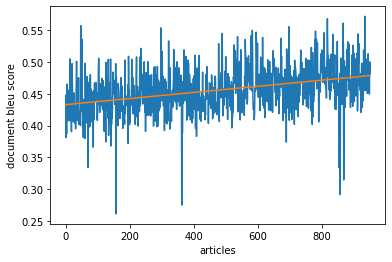

In [ ]:
theta = np.polyfit(model_results.index, model_results[" doc score"], 1)
y_line = theta[1] + theta[0] * model_results.index
plt.plot(model_results.index, model_results[" doc score"])
plt.plot(model_results.index, y_line)
plt.ylabel("document bleu score")
plt.xlabel("articles")
plt.savefig("/content/drive/MyDrive/Practical Deep Learning/Final_Project/doc_score_results.png")


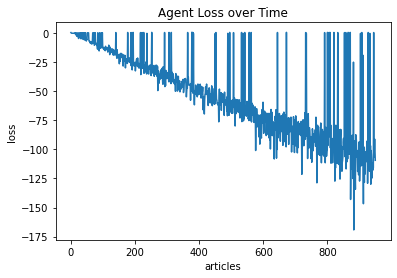

In [ ]:
plt.plot(model_results.index, model_results[" loss"])
plt.xlabel("articles")
plt.ylabel("loss")
plt.title("Agent Loss over Time")
plt.savefig("/content/drive/MyDrive/Practical Deep Learning/Final_Project/training_loss_results.png")

# Demo

In [ ]:
state_size = 768 #
action_size = 2 #
agent = DQN_Agent(state_size, action_size)
agent.load("/content/drive/MyDrive/Practical Deep Learning/Final_Project/saved_models")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          49152     
                                                                 
 gru (GRU)                   (None, 50)                17400     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 66,654
Trainable params: 66,654
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import pandas as pd
articles = pd.read_csv("/content/drive/MyDrive/Practical Deep Learning/Final_Project/articles1.csv")
example = articles.content[5]
example
sent_embeddings = get_sent_embeddings(example)
doc_embedding = get_doc_embeddings(example)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

2021-12-16 19:20:49,928 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim.vectors.npy not found in cache, downloading to /tmp/tmp741ink8z


100%|██████████| 160000128/160000128 [00:07<00:00, 20239699.60B/s]

2021-12-16 19:20:58,212 copying /tmp/tmp741ink8z to cache at /root/.flair/embeddings/glove.gensim.vectors.npy


2021-12-16 19:20:58,407 removing temp file /tmp/tmp741ink8z
2021-12-16 19:20:59,086 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim not found in cache, downloading to /tmp/tmpsgutkxos


100%|██████████| 21494764/21494764 [00:01<00:00, 11971258.89B/s]

2021-12-16 19:21:01,261 copying /tmp/tmpsgutkxos to cache at /root/.flair/embeddings/glove.gensim
2021-12-16 19:21:01,284 removing temp file /tmp/tmpsgutkxos


In [ ]:
sentence_embeddings = sent_embeddings
#initialize 
document_reference = [list(set(get_unigrams(s[1]))) for s in sentence_embeddings]
document_reference = [list(set().union(*document_reference))]

state = []
state.append(doc_embedding.cpu().detach().numpy()) #document embedding
state.append(sentence_embeddings[1][0].cpu().detach().numpy()) #current sentence embedding
state.append(np.zeros(1)) #sentence position
state.append(np.zeros(len(sentence_embeddings))) #partial summary thus far--a one hot vector
t = pad_sequence([torch.tensor(x) for x in state], batch_first=True)
state = tf.convert_to_tensor(t)

doc_score = 0.0
reward=None
#break
n_sents = len(sentence_embeddings)
print("total sents:", n_sents)
#print(n_sents)
#count = 0 
loss = 0
done = True
for l in range(n_sents-1):
    #break
    #total_time += 1
    print("\tsentence:", l)
    # Every update_rate timesteps we update the target network parameters
    #if total_time % agent.update_rate == 0:
        #agent.update_target_model()
          
    # Transition Dynamics
    action = agent.act(state)
    next_state, reward, done = execute_action(action, state, done, sentence_embeddings, document_reference, reward)

    # Store sequence in replay memory
    #agent.remember(state, action, reward, next_state, done)
          
    state = next_state
    doc_score += reward.numpy()

    #reward -= 1  # Punish behavior which does not accumulate reward
    #total_reward += reward.numpy()

final_summary = state.numpy()[3]
print("partial summary one hot: ", final_summary)

total sents: 7
	sentence: 0
	sentence: 1
	sentence: 2


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


	sentence: 3
	sentence: 4
	sentence: 5
partial summary one hot:  [1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [ ]:
from flair.data import Sentence
sents = sent_tokenize(example)
inds = np.where(final_summary==1)

print("original article: ")
all_text = ""
for s in sents:
  all_text += s + "\n"
print(all_text)
  

print("summary text: ")
summary_text = ""
for i in inds[0]:
  summary_text += " " + sents[i] + "\n"
print(summary_text)

original article: 
LONDON  —   Queen Elizabeth II, who has been battling a cold for more than a week, missed a New Year’s Day church service at her country estate in Sandringham, Buckingham Palace said on Sunday.
A week earlier, the queen, who is 90, missed a Christmas Day church service, for the first time since 1988, because of the illness.
“The Queen does not yet feel ready to attend church as she is still recuperating from a heavy cold,” the palace said in a statement.
The queen’s husband, Prince Philip, who had also been ill, was well enough to attend both services, in the church at Sandringham, which is in Norfolk, on the east coast of England.
The queen, who ascended to the throne in 1952, became the world’s   monarch following the death of King Bhumibol Adulyadej of Thailand in October.
She is also Britain’s   monarch, having last year surpassed Queen Victoria’s   reign.
Her mother lived until the age of 101.

summary text: 
 LONDON  —   Queen Elizabeth II, who has been battlin

Extracted Sentences:


**Queen Elizabeth II, who has been battling a cold for more than a week, missed a 
New Year’s Day church service at her country estate in Sandringham, Buckingham 
Palace said on Sunday.
A week earlier, the queen, who is 90, missed a Christmas Day church service, for the first time since 1988, because of the illness.
“The Queen does not yet feel ready to attend church as she is still recuperating from a heavy cold,” the palace said in a statement.**
The queen’s husband, Prince Philip, who had also been ill, was well enough to attend both services, in the church at Sandringham, which is in Norfolk, on the east coast of England.
**The queen, who ascended to the throne in 1952, became the world’s monarch following the death of King Bhumibol Adulyadej of Thailand in October.**
She is also Britain’s monarch, having last year surpassed Queen Victoria’s   reign.
Her mother lived until the age of 101.